# Text classification via Logistic Regression

In the previous notebooks, we covered text preprocessing techniques essential for cleaning and preparing raw text data as well as text representation approaches to convert natural language to a format that is suitable for machine learning models. Now, it's time to see a first application of what we have learned.

In this notebook, we will apply one of the most common machine learning algorithms for text classification: logistic regression. But... What is text classification? And what is logistic regression? Let's look at some definitions.

**Text Classification**: is a branch of Natural Language Processing (NLP) that aims to classify a text into predefined categories. It is typically a supervised learning task, meaning it requires annotated data for training.

**Logistic Regression**: is a statistical model that relates the $\mbox{logit}$ transformation of a dependent variable $\pi$ with a linear combination of some independent variables $x_1, \dots, x_p$. In mathematical terms:

$\mbox{logit}(\pi) =  \log \frac{\pi}{1-\pi} = \beta_0 + \beta_1x_1 + \dots + \beta_px_p$

Where $\pi \in  [0,1]$ is the probability of an outcome and $\beta_i \in \mathbb{R}$ for $i = {0, \dots, p}$ are the coefficients we want to estimate.
The quantity $\frac{\pi}{1-\pi}$ is usually called "odds" and can be interpreted as follows:

_"If I bet \$1.00 on an outcome that has a probability $\pi$ and the outcome happens, I will win $\frac{1-\pi}{\pi} = \mbox{odds}^{-1}\$$ if the game is fair"_

In other words: the greater the odds, the stronger the association between the outcome and the independent variables.

We will implement text classification using logistic regression with the `sklearn` library. (https://scikit-learn.org/stable/index.html)

In [8]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression

As an example of data, we consider a subset of the Coronavirus Tweets NLP dataset, available at [this web page](https://www.kaggle.com/code/nwosurosemary/sentiment-analysis-with-logistic-regression-lstm/input). Let's explore the data.

In [9]:
df_train = pd.read_csv("Corona_NLP_train.csv", encoding = "latin-1")
df_test = pd.read_csv("Corona_NLP_test.csv", encoding = "latin-1")
print("Length of training dataset: ", len(df_train))
print("Length of test dataset: ", len(df_test))
df_train.head()

Length of training dataset:  41157
Length of test dataset:  3798


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


We have 41157 rows in the training dataset and 3798 rows in the test dataset.

The dataset is composed of six columns:
- UserName: A unique identifier for the user.
- ScreenName: The user's screen name or handle on the platform.
- Location: The location provided by the user.
- TweetAt: The date the tweet was posted.
- OriginalTweet: The content of the tweet.
- Sentiment: The sentiment classification of the tweet.

For simplicity, we will consider only the last two columns, remove all the missing values, clean from special characters and map the "Sentiment" column into three labels: "Positive", "Negative", "Neutral".

In [10]:
import re

def map_sentiment(sentiment):
    if sentiment in ['Positive', 'Extremely Positive']:
        return 'Positive'
    elif sentiment in ['Negative', 'Extremely Negative']:
        return 'Negative'
    else:
        return 'Neutral'

def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('r<.*?>',' ', text)
    text = text.split()
    text = ' '.join(text)
    return text

to_keep = ['OriginalTweet', 'Sentiment']
df_train = df_train[to_keep].dropna()
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean)
df_train['Sentiment'] = df_train['Sentiment'].apply(map_sentiment)
df_test = df_test[to_keep].dropna()
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean)
df_test['Sentiment'] = df_test['Sentiment'].apply(map_sentiment)


Now, we deepen our exploration with counting  the number of occurrences of each label.

<ipython-input-11-b026eaeaa8ad>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sentiment', data=df_train, order=sentiment_counts.index,


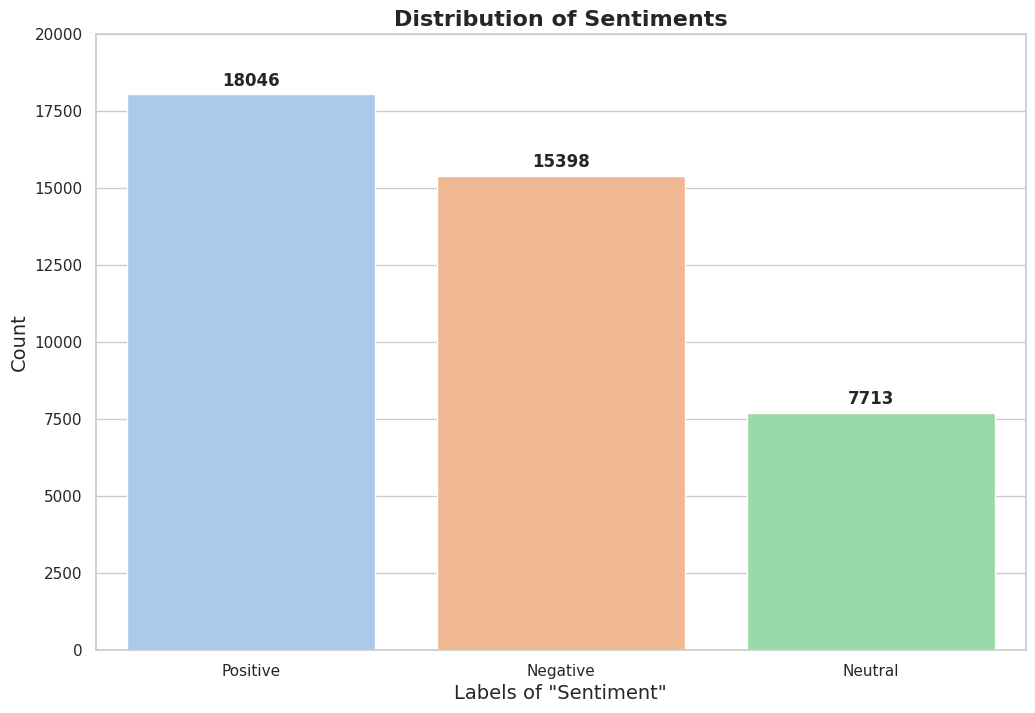

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df_train['Sentiment'].value_counts()

unique_sentiments = df_train['Sentiment'].nunique()
colors = sns.color_palette("pastel", unique_sentiments)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

ax = sns.countplot(x='Sentiment', data=df_train, order=sentiment_counts.index,
                   palette=colors, dodge=False)

plt.title('Distribution of Sentiments', fontsize=16, fontweight='bold')
plt.xlabel('Labels of "Sentiment"', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim((0, 20000))

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points', fontsize=12, fontweight='bold')

plt.show()

We notice that the most frequent label is "Positive" with 18046 occurences, while the least frequent label is "Neutral", with 7713 occurrences. The data is not balanced, but it is not so imbalanced as to require any action.

After a brief Exploratory Data Analysis (EDA), we prepare the data to be fed into the model for training. First of all, we preprocess the texts by converting them to lowercase, removing stopwords, and performing stemming using `nltk`.

In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    words = text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    preprocessed_text = ' '.join(words)

    return preprocessed_text

df_train['ProcessedTweet'] = df_train['OriginalTweet'].apply(preprocess_text)
df_test['ProcessedTweet'] = df_test['OriginalTweet'].apply(preprocess_text)

df_train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,OriginalTweet,Sentiment,ProcessedTweet
0,and and,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,"coronaviru australia: woolworth give elderly, ..."
3,My food stock is not the only one which is emp...,Positive,"food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the outb...",Negative,"me, readi go supermarket outbreak. i'm paranoi..."


Let's save the data to reuse it in the next notebooks!

In [13]:
df_train.to_pickle('df_train.pkl')
df_test.to_pickle('df_test.pkl')

Now, we convert text to numbers using TF-IDF representation and labels to number with `LabelEncoder`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(df_train['ProcessedTweet'])
y_train = label_encoder.fit_transform(df_train['Sentiment'])
X_test = vectorizer.transform(df_test['ProcessedTweet'])
y_test = label_encoder.transform(df_test['Sentiment'])

The extracted features `X_train` represent the terms in the text data, transformed into numerical values using TF-IDF. These numerical features are the independent variables of the logistic regression algorithm, which uses them to learn the relationship between the text and the target labels, enabling it to classify new, unseen text based on the learned patterns.

Now, let's train the model with our data! We can proceed in two different ways:

1. Create three One-Vs-Rest (OVR) models for each label (i.e. first model output is 1 if label is "Positive", 0 otherwise and similarly for the other two models).
2. Create one multinomial model

Let's start with the OVR models.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', multi_class = 'ovr')
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

We can see the performance of the model on the test data using `classification_report`, which calculates the following metrics: precision, recall, F1-score for each class and overall accuracy.

- Precision: This metric indicates the fraction of relevant instances among the retrieved instances. It is calculated as the number of true positives (TP) divided by the sum of true positives and false positives (FP). Precision measures the model's ability to avoid false positives.

- Recall: Also known as sensitivity or true positive rate, recall represents the fraction of relevant instances that have been retrieved over the total amount of relevant instances. It is calculated as the number of true positives (TP) divided by the sum of true positives and false negatives (FN). Recall measures the model's ability to identify all positive instances.

- F1-Score: This is the harmonic mean of precision and recall, providing a single metric that balances both concerns. The F1-score is useful when you need to balance precision and recall.

- Accuracy: This is the overall proportion of correctly classified instances. It is calculated as the number of true positives plus true negatives (TP + TN) divided by the total number of instances. Accuracy provides a general sense of the model’s performance across all classes.





-

In [ ]:
from sklearn.metrics import classification_report

y_pred_test = model.predict(X_test)
print("Test Classification Report:\n")

print(classification_report(y_pred_test, y_test, target_names = label_encoder.classes_))

Test Classification Report:

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      1602
     Neutral       0.60      0.72      0.65       513
    Positive       0.85      0.78      0.82      1683

    accuracy                           0.79      3798
   macro avg       0.75      0.77      0.76      3798
weighted avg       0.79      0.79      0.79      3798



The overall accuracy is 79%. We notice that the lowest result is for the "Neutral" class. This phenomenon could be explained by the scarcity of data for that class. Now, let's try to fit a multinomial logistic regression.

In [ ]:
model = LogisticRegression(solver='sag', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print("Test Classification Report:\n")

print(classification_report(y_pred_test, y_test, target_names = label_encoder.classes_))

Test Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      1589
     Neutral       0.65      0.71      0.68       568
    Positive       0.85      0.80      0.82      1641

    accuracy                           0.79      3798
   macro avg       0.76      0.77      0.77      3798
weighted avg       0.80      0.79      0.79      3798



Still, the overall accuracy is 79% and the performance is approximately the same.

## Conclusion

In this notebook, we explored text classification using logistic regression. We cleaned and preprocessed the data, applied TF-IDF for text representation, and trained logistic regression models using both One-vs-Rest and multi-class approaches. Our model achieved an overall accuracy of 79%, with the "Neutral" class showing the lowest performance due to data scarcity. To achieve better results, more advanced models such as Recurrent Neural Networks and transformers like BERT could be employed. These models can capture the complexities of natural language more effectively, leading to significantly improved performance. We will explore these advanced models in future notebooks.